RNN with BBC

In [111]:
import csv
import numpy as np
import nltk
from time import time

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [112]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, Embedding

In [113]:
MY_VOCAB = 5000 # 학습용으로 사용할 단어의 전체 갯수
MY_EMBED = 64 # 벡터화할 임베딩 규모 (차원)
MY_HIDDEN = 100 # RNN 셀의 규모(숨겨진 레이어층)
MY_LEN = 200 # 업로드할 기사의 전체 단어의 숫자

MY_SPLIT = 0.8 # 학습용 데이터 비율
MY_SAMPLE = 123 # 샘플로 사용할 기사 번호
MY_EPOCH = 10 # 반복 학습 수

In [114]:
original = [] # 기사의 원본을 담는 리스트
processed = [] # 불용어 처리된 기사를 담는 리스트
labels = [] # 기사의 카테고리를 담는 리스트

In [115]:
# NLTK(Natural Language Toolkit)에서 영어의 불용어(stop words)를 다운로드

nltk.download('stopwords') # 기사 분류에 의미없는 영어 단어 다운로드
MY_STOP = set(nltk.corpus.stopwords.words('english'))

# corpus : 텍스트 데이터를 분석/처리 위한 여러 문서나 말뭉치들

print(f'영어 제외어 {MY_STOP}')
print(f'제외어 갯수 {len(MY_STOP)}')
print(type(MY_STOP))
print('the' in MY_STOP)

영어 제외어 {'down', 'why', 'those', 'aren', 'yours', "that'll", "we'd", "weren't", "mustn't", "she's", 'having', 'until', "she'll", "you'd", 'of', 'such', 'been', 'i', 'weren', 'has', 'have', 'his', "shouldn't", 'didn', 'over', 'under', 'our', 'were', 've', 'where', 'wouldn', 'out', 'yourself', 'don', 'shan', 'to', "we've", 'who', 'from', "i'll", 'they', "aren't", "wouldn't", 'but', 'too', "won't", "haven't", 'here', 'ourselves', 'while', 'had', 'through', "doesn't", 'once', "he's", 'up', 'your', 'her', 'hasn', 'doesn', 'being', 'himself', 'own', "i've", 'is', 'it', 'mightn', 'o', 'themselves', "they'll", "you've", 'am', "it'd", 'whom', 'their', 'off', 'd', 'herself', 'can', "he'd", 'shouldn', 'more', 'wasn', "we're", 'after', "didn't", "mightn't", 'when', 'my', 'other', 'both', 'do', 'during', 'into', "isn't", 'theirs', 'at', 'each', 'hadn', 'hers', "wasn't", 'its', "we'll", 'so', 'below', 'by', 'me', "they're", 'she', 'most', 'ain', 'this', 's', 'against', 'an', 'you', 'few', 'no', 'or',

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\main\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [116]:
path = '../RNN/bbc-text.csv'

# 이전 내용 초기화
labels.clear()
original.clear()
processed.clear()
processed_nostop=[]

with open(path, 'r') as file :
    reader = csv.reader(file) # 객체 생성
    header = next(reader) # 상단의 헤드를 읽어 온다
    print(header)
    
    for row in reader:
        labels.append(row[0]) # 각 행의 카테고리이름을 labels 리스트에 추가
        original.append(row[1]) # 각 행의 기사 내용을 original 리스트에 추가
        news = row[1] # 각 행의 두 번째 열 값을 news 변수에 할당
        
        # print('before :' , news) 제외어 처리 전 문장
        for word in MY_STOP:
            # and 라는 불용어 제거시 sand라는 단어까지 s로 바꿔버리는 문제
            mask = ' ' + word + ' ' 
            news = news.replace(mask, ' ')
        # print('after :', news) 제외어 처리 후 문장
        processed.append(news) # 처리된 결과인 news를 processed 리스트에 추가
        
        # 불용어 제거 안한 버전
        processed_nostop.append(row[1])
        
print(f'제외어 처리 전체 기사 수 : {len(processed)}')
print(f'레이블 데이터 수 : {len(labels)}')
print(f'Original 데이터 수 : {len(original)}')
print(f'News 데이터 수 : {len(news)}')

['category', 'text']
제외어 처리 전체 기사 수 : 2225
레이블 데이터 수 : 2225
Original 데이터 수 : 2225
News 데이터 수 : 785


In [117]:
print(f'샘플 기사 원본 : {original[MY_SAMPLE]}')
print(f'샘플 기사 분류 : {labels[MY_SAMPLE]}')
print(f'샘플기사 기사 데이터 : {type(original[MY_SAMPLE])}')
print(f'샘플 기사의 전체 단어 수 : {str(len(original[MY_SAMPLE])).split()}')

print(f'\n제외어를 삭제한 샘플 기사 : {processed[MY_SAMPLE]}')
print(f'제외어 삭제 샘플의 단어 수 : {str(len(processed[MY_SAMPLE])).split()}')
# 정수에 split() 함수를 적용할 수 없기 때문에 
# 문자열을 분할하기 위해 split() 함수를 문자열에 적용해야

샘플 기사 원본 : screensaver tackles spam websites net users are getting the chance to fight back against spam websites  internet portal lycos has made a screensaver that endlessly requests data from sites that sell the goods and services mentioned in spam e-mail. lycos hopes it will make the monthly bandwidth bills of spammers soar by keeping their servers running flat out. the net firm estimates that if enough people sign up and download the tool  spammers could end up paying to send out terabytes of data.   we ve never really solved the big problem of spam which is that its so damn cheap and easy to do   said malte pollmann  spokesman for lycos europe.  in the past we have built up the spam filtering systems for our users   he said   but now we are going to go one step further.    we ve found a way to make it much higher cost for spammers by putting a load on their servers.  by getting thousands of people to download and use the screensaver  lycos hopes to get spamming websites constantly

In [118]:
# 텍스트 데이터를 작은 단위로 분할하는 처리(객체 생성 > 토큰화)
A_token = Tokenizer(num_words=MY_VOCAB,
                    oov_token='!') # out of vocaburary > "!"
A_token.fit_on_texts(processed)

A_token_no = Tokenizer(num_words=MY_VOCAB,
                       oov_token='!')
A_token_no.fit_on_texts(processed_nostop)

print(f'총 기사 수 : {A_token.document_count}')
print(f'총 단어 수 : {len(A_token.word_counts)}')
print(f'각 단어의 사용 횟수 : {A_token.word_counts}')
print(f'단어를 정수로 : {A_token.word_index}')

총 기사 수 : 2225
총 단어 수 : 29698
각 단어의 사용 횟수 : OrderedDict({'tv': 525, 'future': 373, 'hands': 91, 'viewers': 87, 'home': 663, 'theatre': 94, 'systems': 134, 'plasma': 14, 'high': 559, 'definition': 99, 'tvs': 19, 'digital': 415, 'video': 363, 'recorders': 20, 'moving': 79, 'living': 81, 'room': 66, 'way': 740, 'people': 2045, 'watch': 111, 'radically': 10, 'different': 258, 'five': 536, 'years': 1003, 'time': 1322, 'according': 422, 'expert': 29, 'panel': 80, 'gathered': 38, 'annual': 169, 'consumer': 218, 'electronics': 83, 'show': 603, 'las': 31, 'vegas': 30, 'discuss': 59, 'new': 1978, 'technologies': 116, 'impact': 132, 'one': 1892, 'favourite': 110, 'pastimes': 1, 'us': 1972, 'leading': 151, 'trend': 67, 'programmes': 101, 'content': 219, 'delivered': 50, 'via': 129, 'networks': 188, 'cable': 71, 'satellite': 47, 'telecoms': 63, 'companies': 428, 'broadband': 257, 'service': 456, 'providers': 34, 'front': 125, 'rooms': 14, 'portable': 97, 'devices': 161, 'talked': 18, 'about': 22, 'c

In [119]:
# 입력된 텍스트 데이터를 정수 시퀀스로 변환
A_tokenized = A_token.texts_to_sequences(processed)
A_tokenized_no = A_token_no.texts_to_sequences(processed_nostop)

print(f'토큰 처리된 데이터 type : {type(A_tokenized)}')
print(f'토큰 처리된 데이터 수 : {len(A_tokenized)}')
print(f'샘플 기사 토큰 처리본 : {A_tokenized[MY_SAMPLE]}')

토큰 처리된 데이터 type : <class 'list'>
토큰 처리된 데이터 수 : 2225
샘플 기사 토큰 처리본 : [3170, 1, 816, 877, 115, 136, 382, 347, 716, 28, 816, 877, 228, 1, 3171, 27, 3170, 1, 4867, 203, 569, 734, 1770, 126, 4024, 816, 260, 395, 3171, 700, 21, 1647, 3629, 2848, 2606, 1, 2324, 2550, 453, 2918, 570, 115, 63, 2290, 381, 7, 1161, 780, 1858, 2606, 11, 92, 1570, 1051, 1, 203, 281, 154, 1, 138, 364, 816, 1, 2224, 847, 2, 1, 1, 178, 3171, 139, 255, 1109, 816, 1, 726, 136, 2, 52, 60, 10, 818, 3790, 195, 41, 21, 56, 494, 245, 2606, 1363, 1, 2550, 382, 1021, 7, 780, 70, 3170, 3171, 700, 23, 1, 877, 3992, 453, 343, 322, 1393, 3, 1, 2, 3428, 583, 816, 877, 297, 1, 56, 203, 2295, 2402, 2, 3170, 2708, 1069, 660, 812, 1287, 3883, 1538, 1, 466, 224, 503, 1538, 1, 31, 96, 1, 681, 111, 2, 10, 1897, 912, 2, 381, 7, 1161, 1, 877, 11, 722, 256, 1, 1287, 224, 503, 111, 3171, 79, 70, 260, 395, 716, 28, 2, 3, 1, 4, 1603, 10, 823, 455, 158, 823, 455, 2, 569, 2177, 4024, 816, 260, 395, 891, 734, 1770, 126, 221, 3677, 569, 316, 86, 10

In [120]:
longest = max([len(x) for x in A_tokenized])
print(f'제일 긴 기사 단어 수 : {longest}')

shortest = min([len(x) for x in A_tokenized])
print(f'제일 짧은 기사 단어 수 : {shortest}')

제일 긴 기사 단어 수 : 2279
제일 짧은 기사 단어 수 : 50


In [121]:
A_tokenized = pad_sequences(A_tokenized,
                            maxlen = MY_LEN,
                            padding = 'pre',
                            truncating = 'pre')
A_tokenized_no = pad_sequences(A_tokenized_no,
                            maxlen = MY_LEN,
                            padding = 'pre',
                            truncating = 'pre')


print(f'샘플 기사 길이 처리본 \n {A_tokenized[MY_SAMPLE]}')
print(f'토큰 처리된 데이터 수 : {len(A_tokenized)}')

샘플 기사 길이 처리본 
 [   2 3428  583  816  877  297    1   56  203 2295 2402    2 3170 2708
 1069  660  812 1287 3883 1538    1  466  224  503 1538    1   31   96
    1  681  111    2   10 1897  912    2  381    7 1161    1  877   11
  722  256    1 1287  224  503  111 3171   79   70  260  395  716   28
    2    3    1    4 1603   10  823  455  158  823  455    2  569 2177
 4024  816  260  395  891  734 1770  126  221 3677  569  316   86 1051
  816  260  395 3677   23    1 1451  681  111  415  569 3170  760  367
  189   14    1 3883 1594    1 1375  347 3753   27 3171  200    7  660
  569  848  816 1770  569 3258   70 2066 4062 4053  416 3791   77 3629
 2848   11   21  816 1730    2    3    1  569    6 1429 4184  203 4867
  251  664   65  910  231  569    1 3261  136 2819  136 3171  780   70
 3170  297 3170  571  877    1 4867  203 3170  269  633  383  139   35
  233    1 2643  193 4458  611    3    1    2 3170 1965  264   32  231
   12   96  276  430 1538  379    1  816  111 2984  111  323  

In [122]:
longest = max([len(x) for x in A_tokenized])
print(f'제일 긴 기사 단어 수 : {longest}')

shortest = min([len(x) for x in A_tokenized])
print(f'제일 짧은 기사 단어 수 : {shortest}')

제일 긴 기사 단어 수 : 200
제일 짧은 기사 단어 수 : 200


In [123]:
# word_index의 제한 없이, OOV_token 제한없이 라벨만 토큰화

C_token = Tokenizer()
C_token.fit_on_texts(labels) # 라벨만 토큰화

print(f'총 기사 수 : {C_token.document_count}')
print(f'총 단어 수 : {len(C_token.word_counts)}')
print(f'각 단어의 사용 횟수 : {C_token.word_counts}')
print(f'단어를 정수로 : {C_token.word_index}')

총 기사 수 : 2225
총 단어 수 : 5
각 단어의 사용 횟수 : OrderedDict({'tech': 401, 'business': 510, 'sport': 511, 'entertainment': 386, 'politics': 417})
단어를 정수로 : {'sport': 1, 'business': 2, 'politics': 3, 'tech': 4, 'entertainment': 5}


In [124]:
C_tokenized = C_token.texts_to_sequences(labels)
C_tokenized = np.array(C_tokenized).squeeze() -1

print(C_tokenized)

[3 1 0 ... 4 2 0]


In [125]:
X_train, X_test, y_train, y_test = train_test_split(A_tokenized_no,
                                                    C_tokenized,
                                                    train_size=MY_SPLIT,
                                                    shuffle=False)

print(f'학습용 입력 데이터 모양 : {X_train.shape}')
print(f'학습용 출력 데이터 모양 : {y_train.shape}')
print(f'단어를 정수로 : {C_token.word_index}')

학습용 입력 데이터 모양 : (1780, 200)
학습용 출력 데이터 모양 : (1780,)
단어를 정수로 : {'sport': 1, 'business': 2, 'politics': 3, 'tech': 4, 'entertainment': 5}


In [126]:
model = Sequential()
model.add(Embedding(input_dim=MY_VOCAB, output_dim=MY_EMBED))
model.add(Dropout(rate=0.5))
model.add(LSTM(units=MY_HIDDEN))
model.add(Dense(units=5, activation='softmax'))

# 데이터 한 번 넣어서 강제로 빌드
model.build(input_shape=(None, MY_LEN)) # None은 배치 크기

print(" RNN 요약 ")
print(' ======== ')
model.summary()


 RNN 요약 


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 200, 64)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 100)            │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 386,505 (1.47 MB)

 Trainable params: 386,505 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

In [127]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

print('학습 시작')

학습 시작


In [128]:
begin = time()

history = model.fit(X_train, y_train,
                    epochs=MY_EPOCH,
                    verbose=1)

end = time()
print(f'training time : {end-begin:.2f}')

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - acc: 0.2279 - loss: 1.6011
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - acc: 0.3609 - loss: 1.4425
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - acc: 0.6347 - loss: 0.9242
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - acc: 0.7675 - loss: 0.7697
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - acc: 0.8229 - loss: 0.5675
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - acc: 0.8010 - loss: 0.5979
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - acc: 0.8593 - loss: 0.3933
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - acc: 0.8437 - loss: 0.4616
Epoch 9/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - acc: 0.8064 - loss: 0.6342
Epoch 10/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - acc: 0.9077 - loss: 0.2935
training time : 24.55


In [129]:
score = model.evaluate(X_test, y_test, verbose=1)

print(f'최종 정확도 : {score[1]:.2f}')

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.7804 - loss: 0.7019
최종 정확도 : 0.82


In [130]:
pred = model.predict(X_test)
print(f'추측값\n {pred}')
pred = pred.argmax(axis=1)

print(f'추측값(argmax)\n {pred}')


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
추측값
 [[5.08242726e-01 1.12186801e-02 3.22448951e-03 2.60421867e-03
  4.74709809e-01]
 [2.26315763e-02 2.40348935e-01 7.88962394e-02 6.42084718e-01
  1.60386134e-02]
 [1.31273223e-03 7.80541042e-04 9.91606951e-01 5.74033568e-03
  5.59490814e-04]
 ...
 [2.99903035e-01 1.08403735e-01 1.18279763e-01 3.12445909e-02
  4.42168891e-01]
 [1.66204870e-02 9.39147454e-03 8.83790135e-01 8.54041576e-02
  4.79375059e-03]
 [4.41797912e-01 1.39552251e-01 8.53530392e-02 4.11870889e-02
  2.92109609e-01]]
추측값(argmax)
 [0 3 2 4 4 3 1 1 2 3 2 2 1 0 0 3 0 1 0 2 3 1 0 4 1 2 2 0 0 2 1 1 1 1 4 1 2
 2 3 4 0 0 0 1 2 0 0 3 3 1 3 0 1 1 2 0 0 2 3 0 4 0 1 2 2 1 3 2 2 2 2 2 0 0
 3 2 0 2 0 3 0 0 4 4 3 4 3 0 3 0 0 0 4 1 4 0 2 1 0 3 3 2 1 0 1 0 0 2 4 0 0
 1 2 3 2 1 1 0 2 0 0 0 2 3 3 0 4 1 2 0 3 0 0 0 2 1 4 2 0 2 0 2 3 1 2 1 0 0
 1 0 1 4 4 3 3 2 3 2 2 4 0 0 1 3 3 2 0 1 1 1 1 1 1 1 1 0 0 0 1 1 4 1 1 1 2
 0 3 3 3 0 0 0 1 4 3 3 3 2 1 1 3 1 3 0 0 2 2 2 0 0 2 2 3 1 0 0 0 0 1 0 1 1
 2 1 0

In [131]:
print(f'정답\n {y_test.flatten()}')

정답
 [4 3 2 0 0 3 1 3 4 4 2 2 1 4 0 4 4 1 0 2 3 1 0 4 3 2 2 0 0 1 1 1 1 1 4 1 2
 2 3 3 4 2 4 1 2 0 0 1 3 1 3 0 1 1 2 0 0 2 2 4 4 2 1 2 2 1 3 2 2 2 2 2 4 4
 3 2 0 2 0 3 0 0 0 4 3 4 3 0 3 0 0 4 4 1 4 4 2 1 0 3 3 2 1 0 1 4 0 2 4 0 0
 1 2 3 3 1 1 0 2 4 0 0 2 4 3 0 4 1 2 0 2 3 4 0 2 1 4 2 4 2 0 2 1 1 2 1 3 0
 1 4 1 0 0 4 3 2 3 2 2 0 0 0 1 3 4 1 0 1 0 1 3 1 1 1 1 0 0 0 1 1 4 1 1 1 0
 0 0 3 1 0 0 0 1 4 3 3 3 2 1 1 3 1 3 0 0 2 2 2 0 0 2 2 3 1 0 0 0 0 1 0 1 1
 1 1 0 2 0 3 3 0 3 1 4 1 0 1 3 3 2 4 1 4 1 3 2 4 2 4 4 3 1 3 3 1 2 0 4 1 2
 4 1 3 0 3 2 0 2 1 2 2 1 1 1 3 2 1 2 1 4 2 0 2 2 0 4 3 3 1 3 0 1 1 2 0 3 3
 3 0 4 0 2 1 2 2 4 3 1 3 0 4 4 0 1 4 3 3 0 4 1 2 2 2 3 3 1 2 1 2 2 4 0 3 1
 3 4 3 3 0 2 0 0 2 4 4 1 2 2 0 1 1 3 1 3 3 0 1 2 0 1 1 0 3 0 3 4 0 0 4 1 3
 0 0 2 3 1 2 0 0 2 4 3 3 3 1 0 4 4 3 1 2 3 0 0 3 3 2 1 0 4 4 0 4 3 3 1 1 1
 0 0 3 0 1 3 1 1 0 1 2 1 1 3 1 3 2 3 4 2 3 4 0 2 4 1 3 1 3 4 3 0 1 1 2 4 2
 0]


In [132]:
# 결과 비교
correct_predictions = 0
total_predictions = len(y_test)

for i in range(total_predictions):
    if pred[i] == y_test[i]:
        correct_predictions += 1
        
acc = correct_predictions / total_predictions
print(f'정확도 : {acc}')
    

정확도 : 0.8157303370786517


In [133]:
news = ['Bayern Munich cruised to an emphatic 7-0 victory over VfL Bochum\n 5 to move to the top of the German Bundesliga.']

news = A_token.texts_to_sequences(news)
print(news)
print(f'총 단어 수 : {len(news[0])}')

[[1, 4260, 1, 562, 1, 1, 163, 289, 434, 1335, 1, 1, 100, 562, 156, 562, 1125, 66, 1670, 1125, 684, 1]]
총 단어 수 : 22


In [134]:
news = pad_sequences(news, maxlen=MY_LEN,
                     padding='pre',
                     truncating='pre')

print(f'총 단어 수 : {len(news[0])}')

pred = model.predict(news)
pred = pred.argmax(axis=1)
print(f'RNN 추측값 : {pred}')

총 단어 수 : 200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
RNN 추측값 : [2]


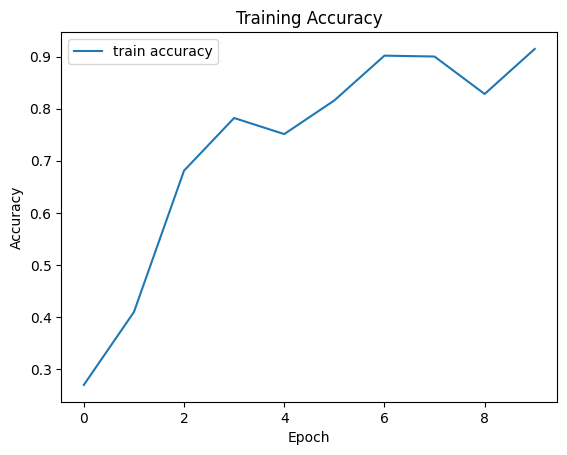

In [135]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'], label='train accuracy')
# plt.plot(history.history['val_acc'], label='train accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


|성능평가   |표준  |제외어    |기사단어수(50)    |기사단어수(50)|
|정확도     |83    | 93
|학습시간   |30.73
|신경망 규모|386,606